In [32]:
import os
from datetime import datetime,timezone,timedelta

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from scipy import signal

import data_filter as dafi
import data_process as dapr
import lib_plot



In [33]:
main_path = os.path.abspath('../data/20221031/3/')

azimut_mask = [270,330]
elevation_mask = [0,50]
min_height = 2
max_height = 6
frequency = dapr.generate_frequency(min_height=min_height,max_height=max_height)
signal_ts_3 = {}

t_range = 15

for dt in tqdm(range(0,t_range-1)):
    starttime = datetime(year=2022,month=10,day=31,hour=8,minute=0+dt,second=0,tzinfo=timezone.utc)
    endtime = datetime(year=2022,month=10,day=31,hour=14,minute=0+dt,second=0,tzinfo=timezone.utc)
    deltatime = timedelta(minutes=t_range)

    data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,elevation_mask=elevation_mask,sn1_trigger=True)

    split_data_dict = dafi.split_data(data_dict,starttime,endtime,deltatime)
    result_dict = dapr.data_prepare(split_data_dict,frequency=frequency)
    result_dict_1031_3 = dapr.extract_height_as_max_peak(result_dict,frequency=frequency)

    for satellite_code in result_dict_1031_3:
        for t,p in zip(result_dict_1031_3[satellite_code]['time'],result_dict_1031_3[satellite_code]['power']):
            if t in signal_ts_3:
                signal_ts_3[t] = np.multiply(p,signal_ts_3[t])
            else:
                signal_ts_3[t] = p
height_ts_3 = {}
for t in signal_ts_3:
    p = signal_ts_3[t]
    index = p==max(p)
    h = frequency[index]
    height_ts_3[t] = h[0]



100%|██████████| 14/14 [04:20<00:00, 18.61s/it]


In [34]:
main_path = os.path.abspath('../data/20221031/2/')

azimut_mask = [270,330]
elevation_mask = [0,50]
min_height = 2
max_height = 6
frequency = dapr.generate_frequency(min_height=min_height,max_height=max_height)
signal_ts_2 = {}

t_range = 15

for dt in tqdm(range(0,t_range-1)):
    starttime = datetime(year=2022,month=10,day=31,hour=8,minute=0+dt,second=0,tzinfo=timezone.utc)
    endtime = datetime(year=2022,month=10,day=31,hour=14,minute=0+dt,second=0,tzinfo=timezone.utc)
    deltatime = timedelta(minutes=t_range)

    data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,elevation_mask=elevation_mask,sn1_trigger=True)

    split_data_dict = dafi.split_data(data_dict,starttime,endtime,deltatime)
    result_dict = dapr.data_prepare(split_data_dict,frequency=frequency)
    result_dict_1031_3 = dapr.extract_height_as_max_peak(result_dict,frequency=frequency)

    for satellite_code in result_dict_1031_3:
        for t,p in zip(result_dict_1031_3[satellite_code]['time'],result_dict_1031_3[satellite_code]['power']):
            if t in signal_ts_2:
                signal_ts_2[t] = np.multiply(p,signal_ts_2[t])
            else:
                signal_ts_2[t] = p
height_ts_2 = {}
for t in signal_ts_2:
    p = signal_ts_2[t]
    index = p==max(p)
    h = frequency[index]
    height_ts_2[t] = h[0]


100%|██████████| 14/14 [03:53<00:00, 16.71s/it]


Text(0.5, 1.0, 'timeseries 31.Okt (elevation 0-50, time window 15 minutes)')

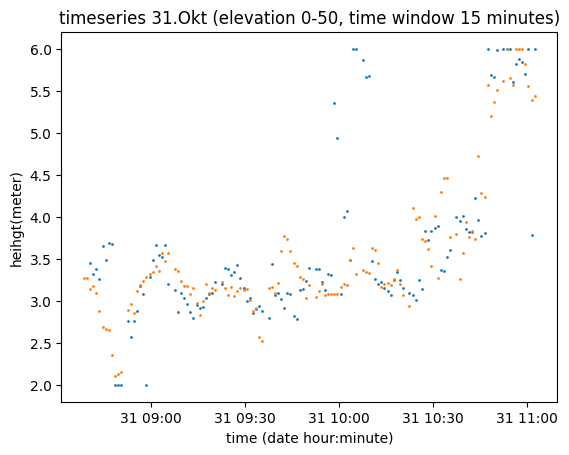

In [35]:
plt.rcParams.update({'font.size': 10})
fig,ax = plt.subplots()
ax.scatter(list(height_ts_2.keys()), list(height_ts_2.values()),s=1)
ax.scatter(list(height_ts_3.keys()), list(height_ts_3.values()),s=1)
ax.set_xlabel('time (date hour:minute)')
ax.set_ylabel('heihgt(meter)')
ax.set_title('timeseries 31.Okt (elevation 0-50, time window 15 minutes)')


In [36]:
main_path = os.path.abspath('../data/20221031/3/')

azimut_mask = [270,330]
elevation_mask = [0,50]
min_height = 2
max_height = 6
frequency = dapr.generate_frequency(min_height=min_height,max_height=max_height)
signal_ts_3 = {}

t_range = 20

for dt in tqdm(range(0,t_range-1)):
    starttime = datetime(year=2022,month=10,day=31,hour=8,minute=0+dt,second=0,tzinfo=timezone.utc)
    endtime = datetime(year=2022,month=10,day=31,hour=14,minute=0+dt,second=0,tzinfo=timezone.utc)
    deltatime = timedelta(minutes=t_range)

    data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,elevation_mask=elevation_mask,sn1_trigger=True)

    split_data_dict = dafi.split_data(data_dict,starttime,endtime,deltatime)
    result_dict = dapr.data_prepare(split_data_dict,frequency=frequency)
    result_dict_1031_3 = dapr.extract_height_as_max_peak(result_dict,frequency=frequency)

    for satellite_code in result_dict_1031_3:
        for t,p in zip(result_dict_1031_3[satellite_code]['time'],result_dict_1031_3[satellite_code]['power']):
            if t in signal_ts_3:
                signal_ts_3[t] = np.multiply(p,signal_ts_3[t])
            else:
                signal_ts_3[t] = p
height_ts_3 = {}
for t in signal_ts_3:
    p = signal_ts_3[t]
    index = p==max(p)
    h = frequency[index]
    height_ts_3[t] = h[0]

main_path = os.path.abspath('../data/20221031/2/')

azimut_mask = [270,330]
elevation_mask = [0,50]
min_height = 2
max_height = 6
frequency = dapr.generate_frequency(min_height=min_height,max_height=max_height)
signal_ts_2 = {}

t_range = 20

for dt in tqdm(range(0,t_range-1)):
    starttime = datetime(year=2022,month=10,day=31,hour=8,minute=0+dt,second=0,tzinfo=timezone.utc)
    endtime = datetime(year=2022,month=10,day=31,hour=14,minute=0+dt,second=0,tzinfo=timezone.utc)
    deltatime = timedelta(minutes=t_range)

    data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,elevation_mask=elevation_mask,sn1_trigger=True)

    split_data_dict = dafi.split_data(data_dict,starttime,endtime,deltatime)
    result_dict = dapr.data_prepare(split_data_dict,frequency=frequency)
    result_dict_1031_3 = dapr.extract_height_as_max_peak(result_dict,frequency=frequency)

    for satellite_code in result_dict_1031_3:
        for t,p in zip(result_dict_1031_3[satellite_code]['time'],result_dict_1031_3[satellite_code]['power']):
            if t in signal_ts_2:
                signal_ts_2[t] = np.multiply(p,signal_ts_2[t])
            else:
                signal_ts_2[t] = p
height_ts_2 = {}
for t in signal_ts_2:
    p = signal_ts_2[t]
    index = p==max(p)
    h = frequency[index]
    height_ts_2[t] = h[0]


100%|██████████| 19/19 [05:04<00:00, 16.01s/it]


Text(0.5, 1.0, 'timeseries 31.Okt (elevation 0-50, time window 20 minutes)')

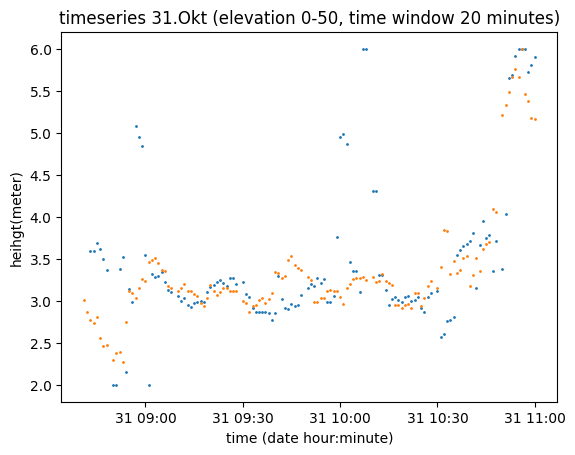

In [37]:
plt.rcParams.update({'font.size': 10})
fig,ax = plt.subplots()
ax.scatter(list(height_ts_2.keys()), list(height_ts_2.values()),s=1)
ax.scatter(list(height_ts_3.keys()), list(height_ts_3.values()),s=1)
ax.set_xlabel('time (date hour:minute)')
ax.set_ylabel('heihgt(meter)')
ax.set_title('timeseries 31.Okt (elevation 0-50, time window 20 minutes)')

In [38]:
main_path = os.path.abspath('../data/20221031/3/')

azimut_mask = [270,330]
elevation_mask = [0,30]
min_height = 2
max_height = 6
frequency = dapr.generate_frequency(min_height=min_height,max_height=max_height)
signal_ts_3 = {}

t_range = 20

for dt in tqdm(range(0,t_range-1)):
    starttime = datetime(year=2022,month=10,day=31,hour=8,minute=0+dt,second=0,tzinfo=timezone.utc)
    endtime = datetime(year=2022,month=10,day=31,hour=14,minute=0+dt,second=0,tzinfo=timezone.utc)
    deltatime = timedelta(minutes=t_range)

    data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,elevation_mask=elevation_mask,sn1_trigger=True)

    split_data_dict = dafi.split_data(data_dict,starttime,endtime,deltatime)
    result_dict = dapr.data_prepare(split_data_dict,frequency=frequency)
    result_dict_1031_3 = dapr.extract_height_as_max_peak(result_dict,frequency=frequency)

    for satellite_code in result_dict_1031_3:
        for t,p in zip(result_dict_1031_3[satellite_code]['time'],result_dict_1031_3[satellite_code]['power']):
            if t in signal_ts_3:
                signal_ts_3[t] = np.multiply(p,signal_ts_3[t])
            else:
                signal_ts_3[t] = p
height_ts_3 = {}
for t in signal_ts_3:
    p = signal_ts_3[t]
    index = p==max(p)
    h = frequency[index]
    height_ts_3[t] = h[0]

main_path = os.path.abspath('../data/20221031/2/')

azimut_mask = [270,330]
elevation_mask = [0,30]
min_height = 2
max_height = 6
frequency = dapr.generate_frequency(min_height=min_height,max_height=max_height)
signal_ts_2 = {}

t_range = 20

for dt in tqdm(range(0,t_range-1)):
    starttime = datetime(year=2022,month=10,day=31,hour=8,minute=0+dt,second=0,tzinfo=timezone.utc)
    endtime = datetime(year=2022,month=10,day=31,hour=14,minute=0+dt,second=0,tzinfo=timezone.utc)
    deltatime = timedelta(minutes=t_range)

    data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,elevation_mask=elevation_mask,sn1_trigger=True)

    split_data_dict = dafi.split_data(data_dict,starttime,endtime,deltatime)
    result_dict = dapr.data_prepare(split_data_dict,frequency=frequency)
    result_dict_1031_3 = dapr.extract_height_as_max_peak(result_dict,frequency=frequency)

    for satellite_code in result_dict_1031_3:
        for t,p in zip(result_dict_1031_3[satellite_code]['time'],result_dict_1031_3[satellite_code]['power']):
            if t in signal_ts_2:
                signal_ts_2[t] = np.multiply(p,signal_ts_2[t])
            else:
                signal_ts_2[t] = p
height_ts_2 = {}
for t in signal_ts_2:
    p = signal_ts_2[t]
    index = p==max(p)
    h = frequency[index]
    height_ts_2[t] = h[0]


100%|██████████| 19/19 [02:22<00:00,  7.51s/it]


Text(0.5, 1.0, 'timeseries 31.Okt (elevation 0-30, time window 20 minutes)')

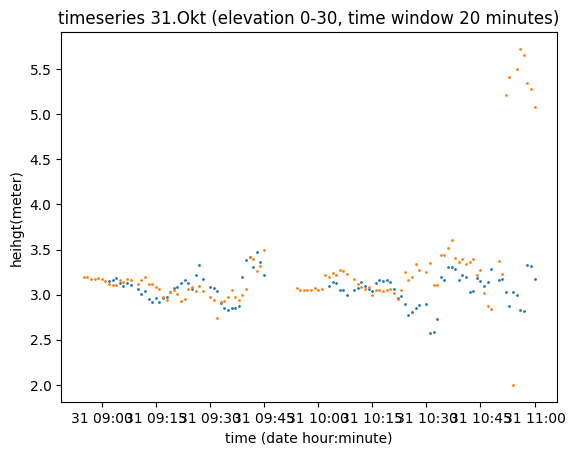

In [39]:
plt.rcParams.update({'font.size': 10})
fig,ax = plt.subplots()
ax.scatter(list(height_ts_2.keys()), list(height_ts_2.values()),s=1)
ax.scatter(list(height_ts_3.keys()), list(height_ts_3.values()),s=1)
ax.set_xlabel('time (date hour:minute)')
ax.set_ylabel('heihgt(meter)')
ax.set_title('timeseries 31.Okt (elevation 0-30, time window 20 minutes)')

In [40]:
gague_insitu = pd.read_csv('20221031_gauge.csv')

In [41]:
gague_insitu

,0,1
0,1667205900,236.34
1,1667206800,236.34
2,1667207700,236.34
3,1667208600,236.34
4,1667209500,236.35
5,1667210400,236.35
6,1667211300,236.35
7,1667212200,236.40
8,1667213100,236.39


In [42]:
time_gauge = []
sur_ele_gauge = []
for time,sur_ele in zip(gague_insitu['0'],gague_insitu['1']):
    t = datetime.fromtimestamp(time)
    time_gauge.append(t)
    sur_ele_gauge.append(sur_ele)

Text(0.5, 1.0, 'surface elevation in DHHN2016')

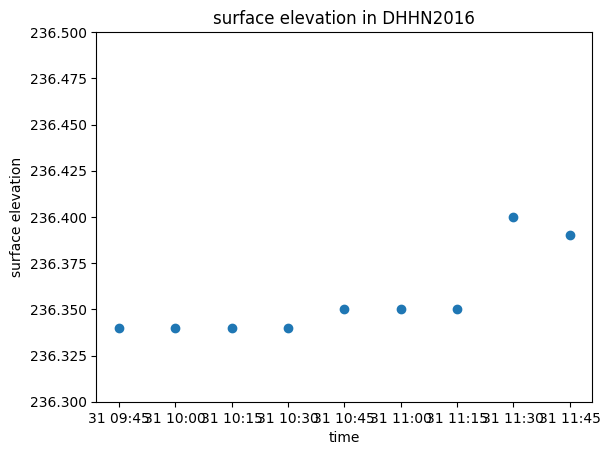

In [43]:
fig,ax = plt.subplots()
ax.scatter(time_gauge,sur_ele_gauge)
ax.set_ylim(236.3,236.5)
ax.set_ylabel('surface elevation')
ax.set_xlabel('time')
ax.set_title('surface elevation in DHHN2016')


In [46]:
data_source = ['Gauge','Altbundle','GNSS height of antenna','gnss-ir dh']
height_system = ['DHHN 2016','XGM 2019','?',np.nan]
df = pd.DataFrame({'data source':data_source,'height system':height_system})
df

,data source,height system
0,Gauge,DHHN2016
1,Altbundle,XGM2019
2,GNSS height of antenna,?
3,gnss-ir dh,NaN
